In [1]:
from Automata import Automata
from utils import *

# Space Specification:

In [2]:
#space=(x1_max, x2_max, x3_range, NX1, NX2, NX3)
space=(10, 10, (-1,1), 50, 50, 15)
#controls = (u1_min, u1_max, u2_min, u2_max, NU1, NU2)
controls = (0.25, 1, -1, 1, 3, 5)
#inputs=(w1,w2,w3,t)
inputs=((0.05,0.05,0.05),1)

# x0_min = 0,0,x3_range[0]
# x0_max = x1_m,x2_m,x3_range[1]
x0_min=(0,0,space[2][0])
x0_max=(space[0],space[1],space[2][1])

In [3]:
def TransFunct(x,u, w, tau):
  z_next = x[2] + tau * (u[1] + w[2]/math.pi)
  # Wrap z to stay within [-1, 1]
  z_range = 2.0  # Range from -1 to 1
  z_wrapped = ((z_next + 1) % z_range) - 1
  return ((x[0]+tau*(u[0]*math.cos(x[2]*math.pi)+w[0])),(x[1]+tau*(u[0]*math.sin(x[2]*math.pi)+w[1])), z_wrapped)

def Dx(u, tau):
  return np.array([[1, 0, tau*abs(u[0])],[0, 1, tau*abs(u[0])],[0, 0, 1]], dtype=float)
def Sx(x_min, x_max):
  return np.array([(x_max[i] - x_min[i]) / 2 for i in range(3)], dtype=float)
def Xx(x_min, x_max):
  return np.array([(x_max[i] + x_min[i]) / 2 for i in range(3)], dtype=float)

def Dw(tau): 
  return np.array([[tau, 0, 0],[0, tau, 0],[0, 0, tau]], dtype=float)
def Sw(w):
  return np.array([w[i] for i in range(3)], dtype=float)
def Wx():
  return [0,0,0]

C:\Users\Student\AppData\Local\Temp\ipykernel_23560\2138766815.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', np.max(list(LabelMap.values())) + 1)


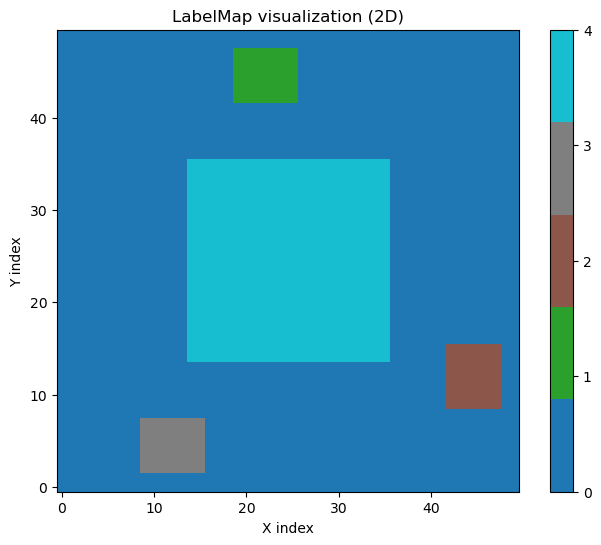

In [4]:
SpecMap = {
    'a' : {0: 'a', 1: 'b', 2: 'c', 3: 'e', 4: 'e'}, # nothing
    'b' : {0: 'b', 1: 'b', 2: 'e', 3: 'd', 4: 'e'}, # reched R1
    'c' : {0: 'c', 1: 'e', 2: 'c', 3: 'd', 4: 'e'}, # reached R2
    'd' : {0: 'e', 1: 'e', 2: 'e', 3: 'd', 4: 'e'}, # accomplished
    'e' : {0: 'e', 1: 'e', 2: 'e', 3: 'e', 4: 'e'}  # trash
}

accepting_states = ['d']
trash_states = ['e']

Rs = {
  4: (((3.0, 3.0, -1), (7.0, 7.0, 1)), True),
  3: (((2.0, 0.5, -1), (3.0, 1.5, 1)), False),
  2: (((8.5, 2.0, -1), (9.5, 3.0, 1)), False),
  1: (((4.0, 8.5, -1), (5.0, 9.5, 1)), False),
}

LabelMap , default_states= build_LabelMap(space, x0_min, x0_max, Rs)

import matplotlib.pyplot as plt
import numpy as np

def plot_LabelMap_2D(LabelMap, space):
    """
    Plots a 2D grid showing the label of each cell based on the first two coordinates.
    Ignores the third dimension (z-axis).
    """
    NX1, NX2 = space[3], space[4]
    
    grid = np.zeros((NX1, NX2))  # Initialize a grid
    
    for (i, j, k), label in LabelMap.items():
        grid[i, j] = label  # Only consider first two coordinates
    
    plt.figure(figsize=(8, 6))
    cmap = plt.cm.get_cmap('tab10', np.max(list(LabelMap.values())) + 1)
    im = plt.imshow(grid.T, origin='lower', cmap=cmap, interpolation='nearest')
    plt.colorbar(im, ticks=np.arange(np.max(list(LabelMap.values()))+1))
    plt.xlabel('X index')
    plt.ylabel('Y index')
    plt.title('LabelMap visualization (2D)')
    plt.show()

# Call the function
plot_LabelMap_2D(LabelMap, space)

# Generation

In [5]:
skip = True
SymbolicController = Automata()

import pickle
try:
    with open("controller_h.pkl", "rb") as f:
        h = pickle.load(f)
    with open("V.pkl", "rb") as f:
        V = pickle.load(f)
except FileNotFoundError:
    print("Warning: controller_h.pkl not found, using SymbolicController.h")
    skip = False

In [6]:
if not skip:
    # step 1: generate the TransitionMap and define the automata
    SymbolicController.set_TransMap(TransMap(x0_min, x0_max, controls, inputs, space, TransFunct, Dx, Dw, Sx, Sw, Xx, Wx))

In [7]:
if not skip:
    # 2. Build product automaton
    SymbolicController.ToProdAutomate(SpecMap, LabelMap, 'a')

In [8]:
if not skip:
    # 3. Define target product states
    target = [(x,q) for (x,q) in SymbolicController.TransMap.keys() if q in accepting_states]

In [9]:
if not skip:
    V = SymbolicController.ApplyReachability(target)
    h = SymbolicController.h

In [10]:
if not skip:
    # 4. Save controller h
    import pickle
    with open("controller_h.pkl", "wb") as f:
        pickle.dump(SymbolicController.h, f)
    with open("V.pkl", "wb") as f:
        pickle.dump(V, f)
    print("Controller saved to controller_h.pkl")

Controller saved to controller_h.pkl


# Visualisation

In [11]:
# Helper functions for concrete simulation

def generate_disturbance(w):
    """Generate random disturbance w within bounds"""
    w1 = np.random.uniform(-w[0], w[0])
    w2 = np.random.uniform(-w[1], w[1])
    w3 = np.random.uniform(-w[2], w[2])
    return (w1, w2, w3)

def discrete_to_concrete_control(discrete_control_idx, controls):
    """Convert discrete control index to concrete control value"""
    CntD = ControlD(controls)
    idx = int(discrete_control_idx)
    if idx < 0 or idx >= len(CntD):
        raise ValueError(f"Control index {idx} out of bounds (0-{len(CntD)-1})")
    return CntD[idx]


def get_discrete_control_index(u, controls):
    """Find the index of control u in the discrete control set"""
    CntD = ControlD(controls)
    for idx, control in enumerate(CntD):
        if np.allclose(control, u, atol=1e-9):
            return idx
    return None

C:\Users\Student\AppData\Local\Temp\ipykernel_23560\2349604192.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', np.max(list(LabelMap.values())) + 1)


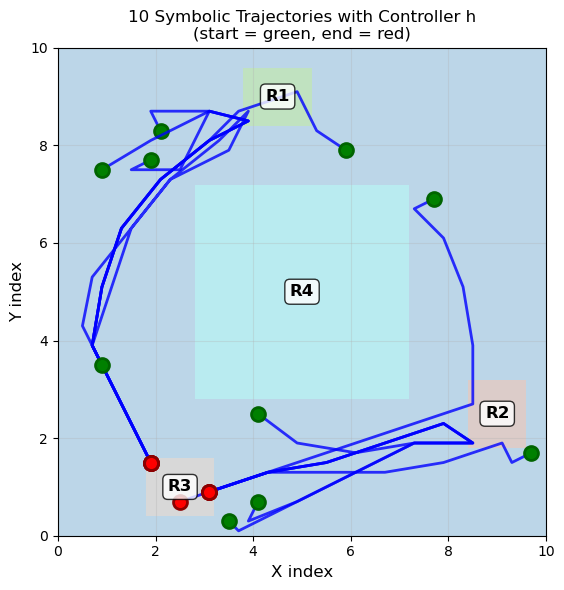

In [12]:
# ============================================================
#   VISUALISE SYMBOLIC TRAJECTORIES (Using BFS)
# ============================================================
import random
import numpy as np
import matplotlib.pyplot as plt

# Number of random trajectories to generate
N_traj = 10

# Pick random starting states from V (reachable states only)
# V contains product states (cell, spec_state) that can reach target
reachable_starts = [state for state in V if state[1] == 'a']  # Only states with spec 'a'
if len(reachable_starts) < N_traj:
    print(f"Warning: Only {len(reachable_starts)} reachable states found, using all of them")
    random_starts = reachable_starts
else:
    random_starts = random.sample(reachable_starts, N_traj)

# Prepare figure
fig, ax = plt.subplots(figsize=(8, 6))

# First, plot the grid cells colored by their labels (like plot_LabelMap_2D)
NX1, NX2 = space[3], space[4]
grid = np.zeros((NX1, NX2))

for (i, j, k), label in LabelMap.items():
    grid[i, j] = label

# Plot the grid with colormap
cmap = plt.cm.get_cmap('tab10', np.max(list(LabelMap.values())) + 1)
im = plt.imshow(grid.T, origin='lower', cmap=cmap, interpolation='nearest', 
                extent=[0, space[0], 0, space[1]], alpha=0.3)

# Draw region boundaries R1–R4
for label, ((rmin, rmax), intersect) in Rs.items():
    xmin, ymin = rmin[0], rmin[1]
    xmax, ymax = rmax[0], rmax[1]
    width, height = xmax - xmin, ymax - ymin
    rect = plt.Rectangle((xmin, ymin), width, height,
                         alpha=0, edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    ax.text((xmin+xmax)/2, (ymin+ymax)/2, f"R{label}",
            ha='center', va='center', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot each trajectory with start/end points highlighted
trajectories_plotted = 0
for start in random_starts:
    traj_states = SymbolicController.bfs_trajectory([start], set(target))
    if traj_states is None:
        continue
    
    traj_centers = np.array([cell_center(s[0], space) for s in traj_states])
    
    # Plot trajectory
    ax.plot(traj_centers[:, 0], traj_centers[:, 1], '-', alpha=0.8, linewidth=2, color='blue')
    
    # Starting point in green
    ax.plot(traj_centers[0, 0], traj_centers[0, 1], 'go', markersize=10, 
            markeredgecolor='darkgreen', markeredgewidth=2)
    
    # Ending point in red
    ax.plot(traj_centers[-1, 0], traj_centers[-1, 1], 'ro', markersize=10,
            markeredgecolor='darkred', markeredgewidth=2)
    
    trajectories_plotted += 1

# Final plot formatting
ax.set_xlim(0, space[0])
ax.set_ylim(0, space[1])

ax.set_xlabel('X index', fontsize=12)

ax.set_ylabel('Y index', fontsize=12)

ax.grid(True, alpha=0.3)

ax.set_title(f"{trajectories_plotted} Symbolic Trajectories with Controller h\n(start = green, end = red)", fontsize=12)
plt.tight_layout()

plt.show()


((0, 41, 9), 'a')
(0.1, 8.3, 0.2666666666666666)
Step 1: x = (np.float64(0.7887052497992214), np.float64(9.021000320392666), np.float64(0.27600977641340974)), Step 2: x = (np.float64(1.425442534755304), np.float64(9.779448912051931), np.float64(-0.23526620173444723)), Step 3: x = (np.float64(2.147875668381463), np.float64(9.12513456997187), np.float64(0.2659945929393772)), Step 4: x = (np.float64(2.8285035198716857), np.float64(9.851284470759191), np.float64(-0.2425460197097189)), Step 5: x = (np.float64(3.5283650892028975), np.float64(9.188128408912418), np.float64(0.2618478999564966)), Step 6: x = (np.float64(3.93134545778031), np.float64(9.609694831628909), np.float64(-0.23982321606056023)), Step 7: x = (np.float64(4.339882081220436), np.float64(9.136492068174414), np.float64(-0.7509769600232811)), Step 8: x = (np.float64(3.608945328494741), np.float64(8.462831843236788), np.float64(-0.7493094243406102)), Step 9: x = (np.float64(2.8578607308405886), np.float64(7.7912087600744835), n

C:\Users\Student\AppData\Local\Temp\ipykernel_23560\1335739640.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', np.max(list(LabelMap.values())) + 1)


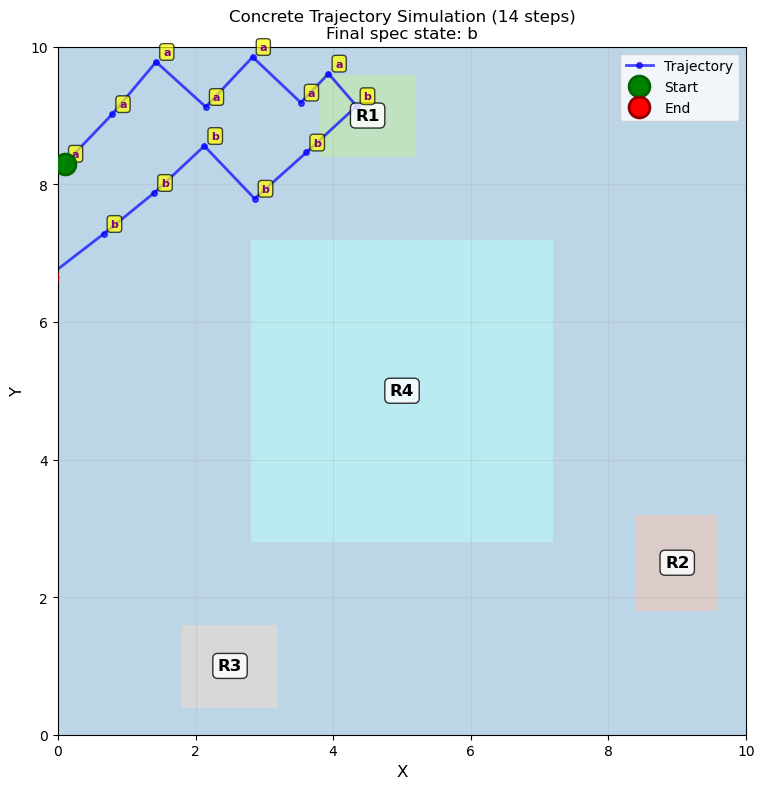


Trajectory summary:
  Total steps: 14
  Final position: (-0.16, 6.65, -0.79)
  Final spec state: b


In [13]:
# select a random state from V where [1] == 'a'
reachable_starts = [state for state in V if state[1] == 'a']  # Only states with spec 'a'
fixed_start = random.choice(reachable_starts)
print(fixed_start)

fixed_start_cell = fixed_start[0]
fixed_start_spec = fixed_start[1]

x = cell_center(fixed_start_cell, space)
print(x)

# determine u:
u = h[fixed_start]
spec_state = fixed_start_spec

import matplotlib.pyplot as plt
import numpy as np

# Storage for trajectory
trajectory = [x]
spec_states = [spec_state]

for i in range(50):
    w = generate_disturbance(inputs[0])
    x = TransFunct(x, u, w, tau=inputs[1])
    
    trajectory.append(x)
    
    # Check if x or y went out of bounds
    if not (0 <= x[0] <= space[0] and 0 <= x[1] <= space[1]):
        print(f"OUT OF BOUNDS at step {i+1}! x={x[0]:.3f}, y={x[1]:.3f}")
        break
    
    state = continuous_to_cell(x, space)
    print(f"Step {i+1}: x = {x}, ", end='')

    spec_state = SpecMap[spec_state][LabelMap[state]]
    spec_states.append(spec_state)
    
    if spec_state == 'e':
        print("Entered trash state 'e', stopping simulation.")
        break
    elif spec_state == 'd':
        print("Reached accepting state 'd', stopping simulation.")
        break
    
    u = h[(state, spec_state)]

# Convert trajectory to numpy array for plotting
trajectory = np.array(trajectory)

# Create visualization
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the grid cells colored by their labels
NX1, NX2 = space[3], space[4]
grid = np.zeros((NX1, NX2))

for (i, j, k), label in LabelMap.items():
    grid[i, j] = label

# Plot the grid with colormap
cmap = plt.cm.get_cmap('tab10', np.max(list(LabelMap.values())) + 1)
im = plt.imshow(grid.T, origin='lower', cmap=cmap, interpolation='nearest', 
                extent=[0, space[0], 0, space[1]], alpha=0.3)

# Draw region boundaries R1–R4
for label, ((rmin, rmax), intersect) in Rs.items():
    xmin, ymin = rmin[0], rmin[1]
    xmax, ymax = rmax[0], rmax[1]
    width, height = xmax - xmin, ymax - ymin
    rect = plt.Rectangle((xmin, ymin), width, height,
                         alpha=0, edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    ax.text((xmin+xmax)/2, (ymin+ymax)/2, f"R{label}",
            ha='center', va='center', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot trajectory
ax.plot(trajectory[:, 0], trajectory[:, 1], '-o', alpha=0.7, linewidth=2, 
        markersize=4, color='blue', label='Trajectory')

# Mark start point
ax.plot(trajectory[0, 0], trajectory[0, 1], 'go', markersize=15, 
        markeredgecolor='darkgreen', markeredgewidth=2, label='Start', zorder=10)

# Mark end point
ax.plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', markersize=15,
        markeredgecolor='darkred', markeredgewidth=2, label='End', zorder=10)

# Add spec state annotations at key points
step_interval = max(1, len(trajectory) // 10)  # Show ~10 annotations
for i in range(0, len(trajectory), step_interval):
    if i < len(spec_states):
        ax.annotate(f"{spec_states[i]}", 
                   xy=(trajectory[i, 0], trajectory[i, 1]),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=8, color='purple', fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax.set_xlim(0, space[0])
ax.set_ylim(0, space[1])
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right')
ax.set_title(f'Concrete Trajectory Simulation ({len(trajectory)} steps)\nFinal spec state: {spec_states[-1]}', 
             fontsize=12)

plt.tight_layout()
plt.show()

print(f"\nTrajectory summary:")
print(f"  Total steps: {len(trajectory)}")
print(f"  Final position: ({trajectory[-1, 0]:.2f}, {trajectory[-1, 1]:.2f}, {trajectory[-1, 2]:.2f})")
print(f"  Final spec state: {spec_states[-1]}")